In [ ]:

import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
torch.manual_seed(42)

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train[0].shape

(28, 28)

In [ ]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


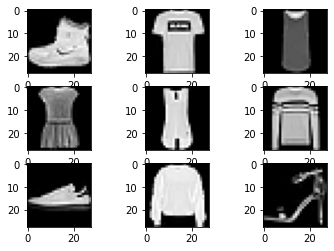

In [ ]:
import matplotlib.pyplot as plt
for i in range(9):	
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
BATCH_SIZE = 256

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) 

torch_X_train = torch_X_train.view(-1,1,28,28).float()
torch_X_train.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([60000, 1, 28, 28])

In [ ]:
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

torch_X_test = torch_X_test.view(-1,1,28,28).float()

In [ ]:
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = Fulse)

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = 3)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size = 5)
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv5_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(2048, 512)
        self.fc1_bn = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 50)
        self.fc2_bn = nn.BatchNorm1d(50)
        self.fc3 = nn.Linear(50 , 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(self.conv2_bn(x), 2))
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        x = self.conv5(x)
        x = F.relu(self.conv5_drop(self.conv5_bn(x)))
        x = x.view(-1, 2048)
        x = self.fc1(x)
        x = F.relu(self.fc1_bn(x))
        x = self.fc2(x)
        x = F.relu(self.fc2_bn(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x)

In [ ]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc1_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): 

In [ ]:
it = iter(train_loader)
X_batch, y_batch = next(it)
print(X_batch.shape)
print(y_batch.shape)

if torch.cuda.is_available():
    X_batch = X_batch.cuda()
    y_batch = y_batch.cuda()
    
print(cnn.forward(X_batch).shape)

torch.Size([256, 1, 28, 28])
torch.Size([256])
torch.Size([256, 10])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx == 0:
        print(data.shape)
        print(target.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256])


In [ ]:
learning_rate = 0.01
momentum = 0.5
n_epochs = 15

optimizer = optim.SGD(cnn.parameters(), lr=learning_rate,momentum=momentum)
scheduler = StepLR(optimizer,step_size=1 , gamma=0.9)

In [ ]:
train_losses = []
train_counter = []
test_losses = []

In [ ]:
def train(epoch):
    cnn.train()
    train_loss = 0
    scheduler.step()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = cnn(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 25 == 0: #every 25 * batchsize sample we print results
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
      
        train_loss += loss.item()

    train_losses.append(train_loss)
    train_counter.append(epoch)

    torch.save(cnn.state_dict(), 'model.pth')
    torch.save(cnn.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  cnn.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = cnn(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.428916
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.488712
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.210967
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.096064
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.982303
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.910973
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.858656
Train Epoch: 1 [44800/60000 (74%)]	Loss: 0.851707
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.776909
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.706719


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5833, Accuracy: 8210/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.702258
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.740669
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.701475
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.670036
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.629678
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.631750
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.641136
Train Epoch: 2 [44800/60000 (74%)]	Loss: 0.660413
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.565957
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.548489

Test set: Avg. loss: 0.4213, Accuracy: 8665/10000 (87%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.544160
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.569101
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.468682
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.550347
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.519762
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.500497
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.479412
Train Epoch: 3 [44800/60000 (74%)]	Loss: 0.582

### Transfer Learning


In [ ]:
train_set = torchvision.datasets.FashionMNIST(
root = './data/FashionMNIST',
download = True,
train = True,
transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
]))

test_set = torchvision.datasets.FashionMNIST(
root = './data/FashionMNIST',
download=True,
train=False,
transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
]))

In [ ]:
train_set.data[0].shape

torch.Size([28, 28])

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_loaderr = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = False)
test_loaderr = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

In [ ]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
learning_rate = 0.01
momentum = 0.5
n_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=momentum)
scheduler = StepLR(optimizer,step_size=2 , gamma=0.9)

In [ ]:
train_lossesr = []
train_counterr = []
test_lossesr = []

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loaderr):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 300 == 0: #every 300 * batchsize sample we print results
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loaderr.dataset),
            100. * batch_idx / len(train_loaderr), loss.item()))
      
        train_loss += loss.item()
    scheduler.step()
    train_lossesr.append(train_loss)
    train_counterr.append(epoch)

    torch.save(model.state_dict(), 'model.pth')
    torch.save(model.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loaderr:

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(test_loaderr.dataset)
  test_lossesr.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loaderr.dataset),
    100. * correct / len(test_loaderr.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.432032
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.685344
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.665854
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.543844

Test set: Avg. loss: 0.0086, Accuracy: 8123/10000 (81%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.527213
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.524524
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.605682
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.496376

Test set: Avg. loss: 0.0079, Accuracy: 8257/10000 (83%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.464718
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.491414
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.591919
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.467956

Test set: Avg. loss: 0.0076, Accuracy: 8310/10000 (83%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.440722
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.476341
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.585717
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.450285

Test set: Avg. loss: 0.0074, Accuracy: 8342/1